In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.svm import SVC, SVR

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, precision_recall_curve,balanced_accuracy_score,make_scorer,f1_score,classification_report

In [45]:
df = pd.read_csv("AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")

C:\Users\sebas\AppData\Local\Temp\ipykernel_4716\713402779.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")


In [46]:
# z kolumny 'Event.Date' wyciągamy do osobnych kolumn rok, miesiąc i dzień
df['Year'] = df['Event.Date'].dt.year
df['Month'] = df['Event.Date'].dt.month_name()
df['Day'] = df['Event.Date'].dt.day_name()

# z kolumny 'Location' wyciągamy do osbnych kolumn miasto i stan
df['City'] = df['Location'].str.split(',').str[0]
df['State'] = df['Location'].str.split(',').str[1]

# 'Unk' i 'UNK' zamieniamy na jedną wartość 'Unknown'
df['Weather.Condition'].replace(to_replace = ['Unk', 'UNK'], value = 'Unknown', inplace = True)

# wartości np. Fatal(1), Fatal(123) zamieniamy na jedną wartość 'Fatal'
df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')

# puste wartości uzupełniamy najczęściej występującymi wartościami w danej kolumnie
df['Purpose.of.flight'] = df['Purpose.of.flight'].fillna(df['Purpose.of.flight'].mode()[0])
df['Weather.Condition'] = df['Weather.Condition'].fillna(df['Weather.Condition'].mode()[0])
df['Engine.Type'] = df['Engine.Type'].fillna(df['Engine.Type'].mode()[0])
df['Model'] = df['Model'].fillna(df['Model'].mode()[0])

# w kolumnie number.of.Engines średnia oraz mediana jest podabna, wiec uzupełniam puste wartosci medianą
df['Number.of.Engines'].fillna(df['Number.of.Engines'].median(), inplace=True)

C:\Users\sebas\AppData\Local\Temp\ipykernel_4716\850482051.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')


In [47]:
# poniższy kod zamienia wszystkie wartości NaN na 'Unavailable' albo 'Unknown' dla kolumn gdzie już takie wartości występują. 
# Dzięki temu po późniejszym zastosowaniu df.dropna() zamiast 50k rekordów zostaje aż 77k. 
# Pytanie tylko czy wartości 'Unknown' w modelu mają jakikolwiek sens i czy nie lepiej faktycznie zredukować dane do tych 50k.
'''
df['Injury.Severity'] = df['Injury.Severity'].fillna('Unavailable')
df['Aircraft.damage'] = df['Aircraft.damage'].fillna('Unknown')
df['Weather.Condition'] = df['Weather.Condition'].fillna('Unknown')
df['Broad.phase.of.flight'] = df['Broad.phase.of.flight'].fillna('Unknown')
df['Make'] = df['Make'].fillna('Unknown')
'''

"\ndf['Injury.Severity'] = df['Injury.Severity'].fillna('Unavailable')\ndf['Aircraft.damage'] = df['Aircraft.damage'].fillna('Unknown')\ndf['Weather.Condition'] = df['Weather.Condition'].fillna('Unknown')\ndf['Broad.phase.of.flight'] = df['Broad.phase.of.flight'].fillna('Unknown')\ndf['Make'] = df['Make'].fillna('Unknown')\n"

In [48]:
df = df.dropna()

In [49]:
df.groupby('Broad.phase.of.flight')['Total.Fatal.Injuries'].agg(['count', 'min', 'max', 'mean', 'sum'])

,count,min,max,mean,sum
Broad.phase.of.flight,,,,,
Approach,5415,0.0,228.0,0.705263,3819.0
Climb,1649,0.0,230.0,1.056398,1742.0
Cruise,8391,0.0,111.0,0.721249,6052.0
Descent,1454,0.0,82.0,0.621733,904.0
Go-around,1116,0.0,37.0,0.524194,585.0
Landing,11614,0.0,34.0,0.042793,497.0
Maneuvering,7104,0.0,68.0,0.741132,5265.0
Other,96,0.0,11.0,0.875000,84.0
Standing,553,0.0,34.0,0.195298,108.0


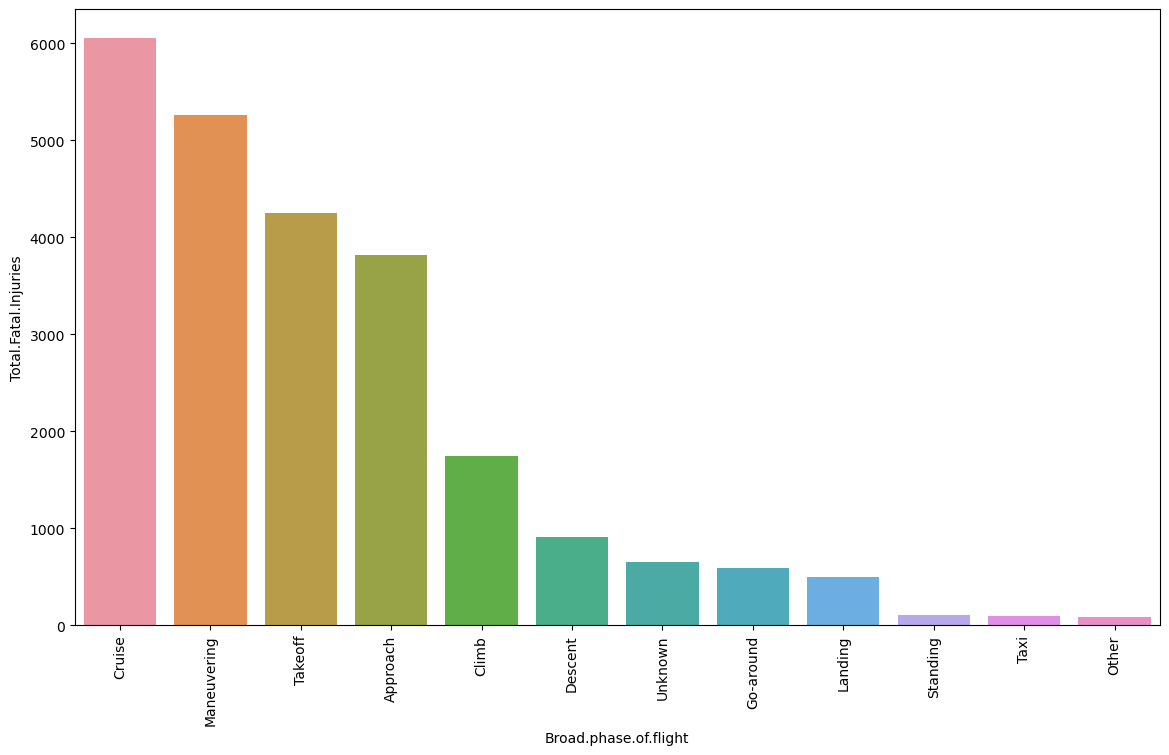

In [54]:
phase_flight_grouped= df.groupby("Broad.phase.of.flight").sum('Total.Fatal.Injuries').reset_index().sort_values(by='Total.Fatal.Injuries',ascending=False)

plt.figure(figsize=(14,8))
sns.barplot(data = phase_flight_grouped, x = phase_flight_grouped['Broad.phase.of.flight'],y= phase_flight_grouped['Total.Fatal.Injuries'], estimator = sum)
plt.xticks(rotation=90)
plt.show()

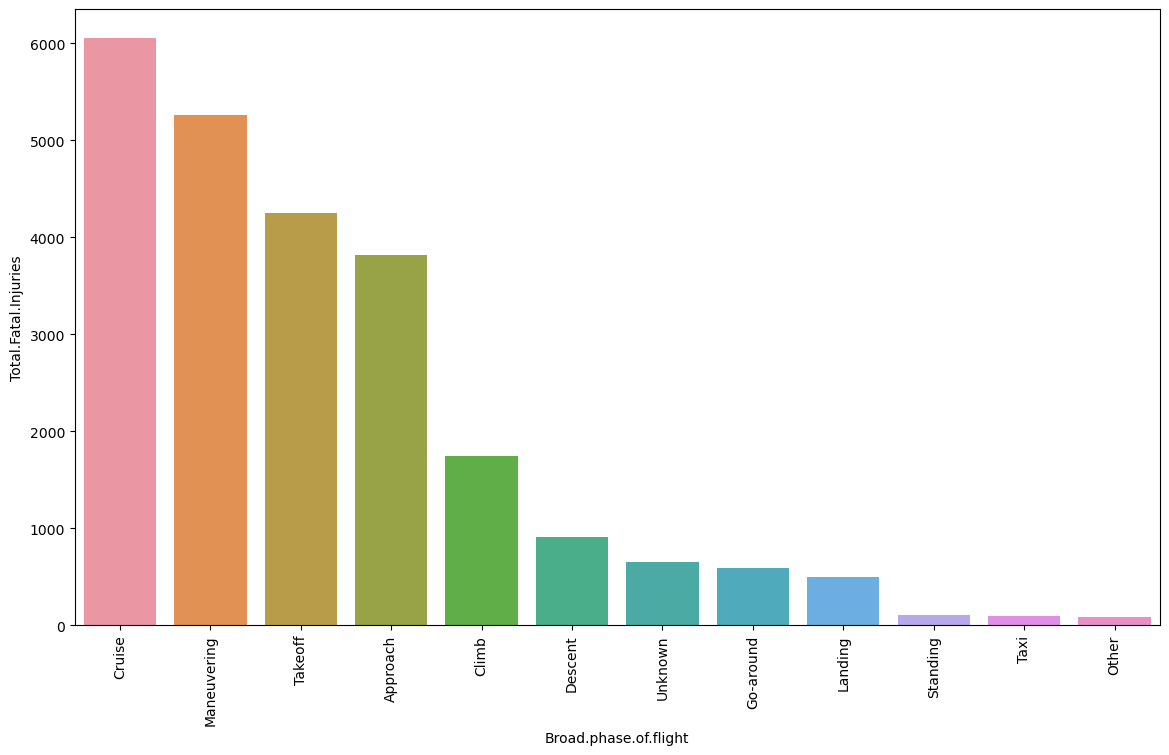

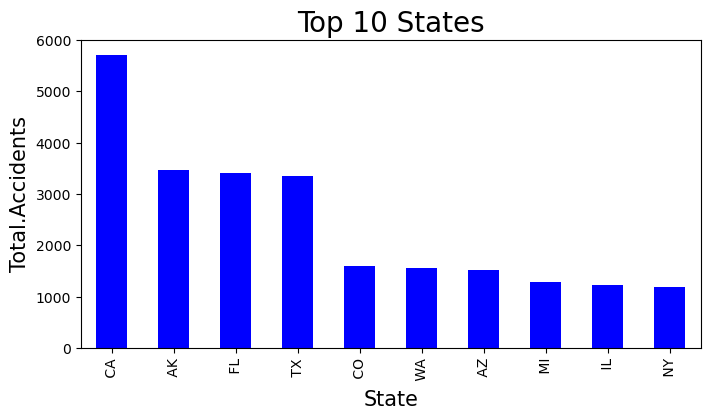

In [8]:
plt.figure(figsize=(8,4))
df['State'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xticks(rotation=90)
plt.xlabel("State", size=15)
plt.ylabel("Total.Accidents", size=15)
plt.title("Top 10 States", size=20)
plt.show()

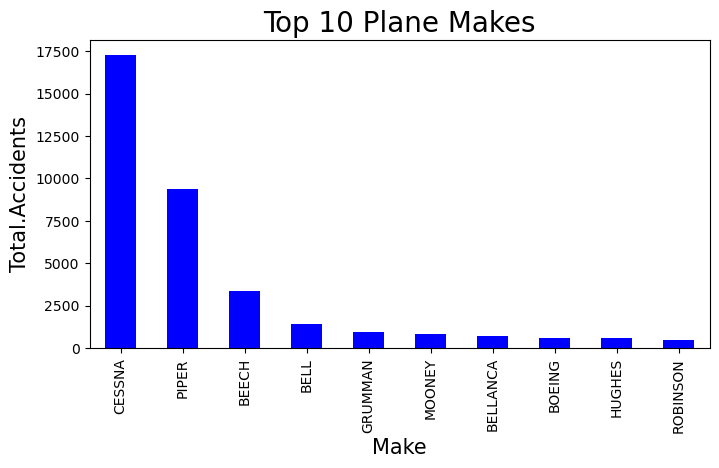

In [9]:
plt.figure(figsize=(8,4))
df['Make'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xticks(rotation=90)
plt.xlabel("Make", size=15)
plt.ylabel("Total.Accidents", size=15)
plt.title("Top 10 Plane Makes", size=20)
plt.show()

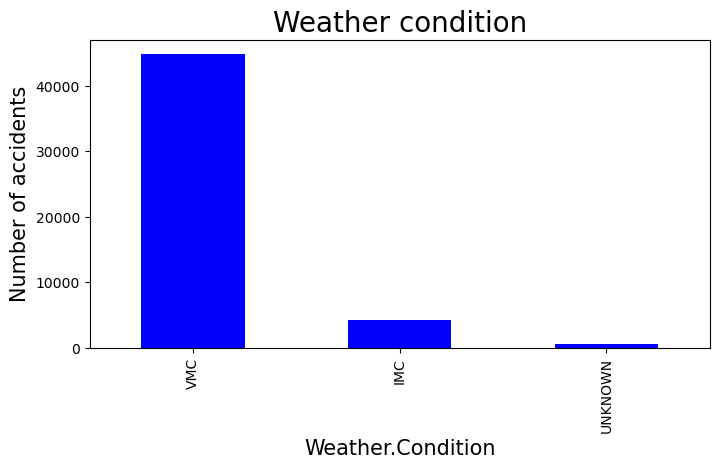

In [10]:
plt.figure(figsize=(8,4))
df['Weather.Condition'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xlabel("Weather.Condition", size=15)
plt.ylabel("Number of accidents", size=15)
plt.title("Weather condition", size=20)
plt.show()

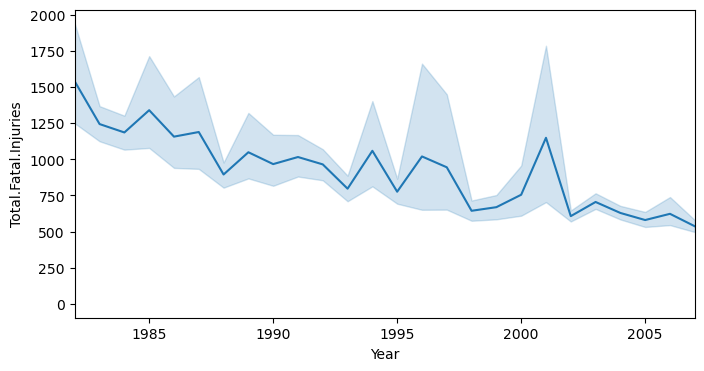

In [11]:
plt.figure(figsize = (8,4))
ax = sns.lineplot(data = df, x = df['Year'], y= df['Total.Fatal.Injuries'],estimator=sum)
ax.set_xlim(1982,2007)
plt.show()

<AxesSubplot:xlabel='Weather.Condition', ylabel='Total.Fatal.Injuries'>

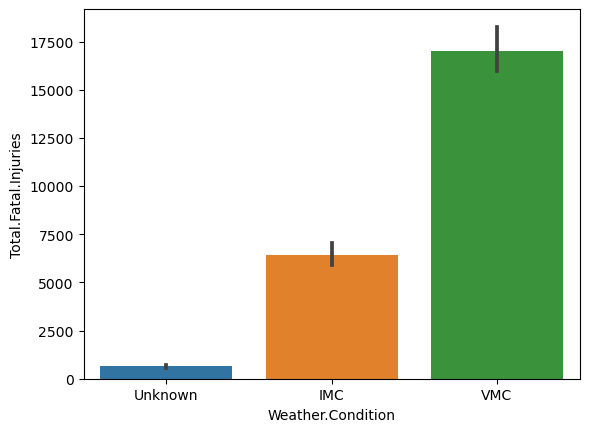

In [12]:
sns.barplot(data=df,x='Weather.Condition',y='Total.Fatal.Injuries',estimator=sum)

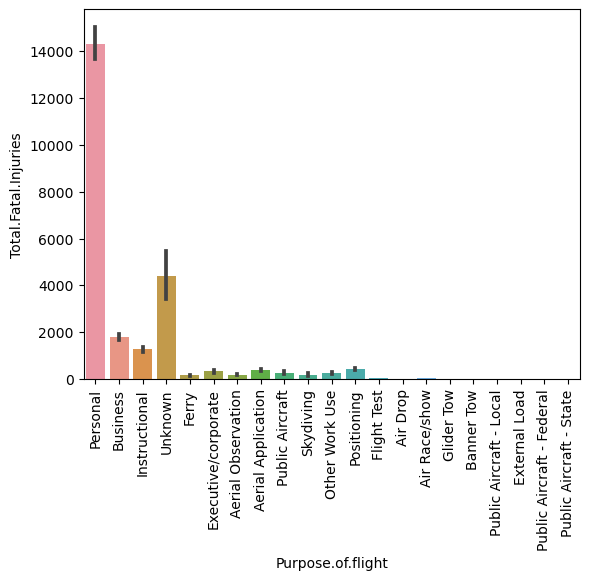

In [13]:
sns.barplot(data = df,x=df['Purpose.of.flight'],y=df['Total.Fatal.Injuries'],estimator=sum)
plt.xticks(rotation=90);

In [14]:
df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Year
count,49498.000000,49498.000000,49498.000000
mean,1.134470,0.486040,1990.650693
std,0.410456,2.872832,6.206839
min,0.000000,0.000000,1948.000000
25%,1.000000,0.000000,1985.000000
50%,1.000000,0.000000,1990.000000
75%,1.000000,0.000000,1996.000000
max,4.000000,265.000000,2007.000000


In [15]:
df = df.reset_index()

___

In [16]:
df['Total.Fatal.Injuries_encoded'] = df['Total.Fatal.Injuries'].where(df['Total.Fatal.Injuries'] ==0, other=1)

In [17]:
df['Total.Fatal.Injuries_encoded'].value_counts()

0.0    38128
1.0    11370
Name: Total.Fatal.Injuries_encoded, dtype: int64

In [18]:
df_X = df[['Number.of.Engines', 'Engine.Type','Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight', 'Month']]

In [19]:
lista_kolumn_X = list(df_X.columns)

for i in lista_kolumn_X:
    print(i, df_X[i].value_counts().count())

Number.of.Engines 5
Engine.Type 6
Purpose.of.flight 21
Weather.Condition 3
Broad.phase.of.flight 12
Month 12


In [20]:
df_X_get_dummies = pd.get_dummies(df_X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_X_get_dummies, df['Total.Fatal.Injuries_encoded'], test_size=0.3,random_state=123)

In [22]:
#RandomForestClassifier
'''
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
rf_cls = RandomForestClassifier(max_depth=3)
rf_cls = rf_cls.fit(X_train, y_train)

pred_train = rf_cls.predict(X_train)
pred_test = rf_cls.predict(X_test)
print(classification_report(y_train,pred_train))
print(classification_report(y_test,pred_test))

pred_train_proba =  rf_cls.predict_proba(X_train)[:,1]
pred_test_proba = rf_cls.predict_proba(X_test)[:,1]
roc_auc_score(y_train,pred_train_proba)
roc_auc_score(y_test,pred_test_proba)

fpr_train, tpr_train, thresholds =roc_curve(y_train, pred_train_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test,pred_test_proba)

plt.plot(fpr_train,tpr_train, color='r')
plt.plot(fpr_test,tpr_test, color='b')
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),'--')
plt.show()

print(f'Score train: {rf_cls.score(X_train,y_train)}')
print(f'Score train: {rf_cls.score(X_test,y_test)}')

rf_cls.feature_importances_
rf_cls.feature_names_in_

df_importance = pd.DataFrame(rf_cls.feature_importances_,rf_cls.feature_names_in_,columns=['importance']).sort_values(by='importance',ascending=False)
df_importance
'''

"\nfrom sklearn.metrics import classification_report\nfrom sklearn.metrics import roc_auc_score, roc_curve\nrf_cls = RandomForestClassifier(max_depth=3)\nrf_cls = rf_cls.fit(X_train, y_train)\n\npred_train = rf_cls.predict(X_train)\npred_test = rf_cls.predict(X_test)\nprint(classification_report(y_train,pred_train))\nprint(classification_report(y_test,pred_test))\n\npred_train_proba =  rf_cls.predict_proba(X_train)[:,1]\npred_test_proba = rf_cls.predict_proba(X_test)[:,1]\nroc_auc_score(y_train,pred_train_proba)\nroc_auc_score(y_test,pred_test_proba)\n\nfpr_train, tpr_train, thresholds =roc_curve(y_train, pred_train_proba)\nfpr_test, tpr_test, thresholds_test = roc_curve(y_test,pred_test_proba)\n\nplt.plot(fpr_train,tpr_train, color='r')\nplt.plot(fpr_test,tpr_test, color='b')\nplt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),'--')\nplt.show()\n\nprint(f'Score train: {rf_cls.score(X_train,y_train)}')\nprint(f'Score train: {rf_cls.score(X_test,y_test)}')\n\nrf_cls.feature_importances_\n

### XGB

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_X_get_dummies, df['Total.Fatal.Injuries_encoded'], test_size=0.3,random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [24]:
params = { 
    "booster": "gbtree",
    "learning_rate": 0.5
}

In [25]:
def balanced_accuracy(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = (preds > 0.5).astype(int)
    return 'balanced_accuracy', balanced_accuracy_score(labels, preds_binary)

In [26]:
# for max_depth in [2,3,4,5,6,7,8,9]:
#     my_params = {"max_depth": max_depth}
#     my_params.update(params)
#     cv_results = xgb.cv(
#         dtrain=dtrain, 
#         params=my_params, 
#         nfold=5, 
#         num_boost_round=100, 
#         custom_metric=balanced_accuracy,
#         as_pandas=True)
#     best_rounds = cv_results['test-balanced_accuracy-mean'].idxmax()
#     score = cv_results['test-balanced_accuracy-mean'].max()
#     print("For max_depth {} the best result was {} after {} rounds".format(
#         max_depth, score, best_rounds
#     ))

In [27]:
my_params = {'max_depth':5,'n_estimators':74}
my_params.update(params)

In [28]:
best_model = xgb.XGBClassifier(**my_params)
best_model.fit(X_train,y_train)

preds = best_model.predict(X_test)
probas = best_model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, probas), f1_score(y_test, preds)

(0.8123220866272829, 0.5378879833535634)

In [29]:
best_model.score(X_test, y_test)

0.8205387205387206

In [30]:
y_pred = best_model.predict(X_test)

In [31]:
acc = accuracy_score(y_test,y_pred)
balanced_acc = balanced_accuracy_score(y_test,y_pred)

print(f'Accuracy score: {acc}')
print(f'Balanced accuracy score: {balanced_acc}')


Accuracy score: 0.8205387205387206
Balanced accuracy score: 0.6938114894269347


In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     11499
         1.0       0.64      0.46      0.54      3351

    accuracy                           0.82     14850
   macro avg       0.75      0.69      0.71     14850
weighted avg       0.81      0.82      0.81     14850



In [33]:
cm = confusion_matrix(y_test,y_pred)

In [34]:
cm

array([[10634,   865],
       [ 1800,  1551]], dtype=int64)

Opis wykresu - korelacja

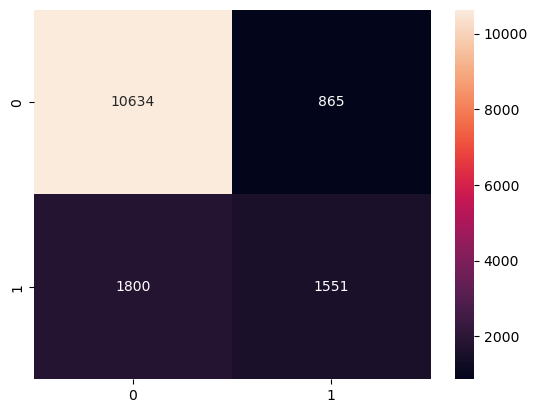

In [39]:
kor =sns.heatmap(cm,annot=True,fmt='g')
display(kor)

In [40]:
display(kor)

<AxesSubplot:>

In [36]:
probas = best_model.predict_proba(X_test)

In [37]:
positive_proba = probas[:, 1]

Text(0, 0.5, 'True positive rate')

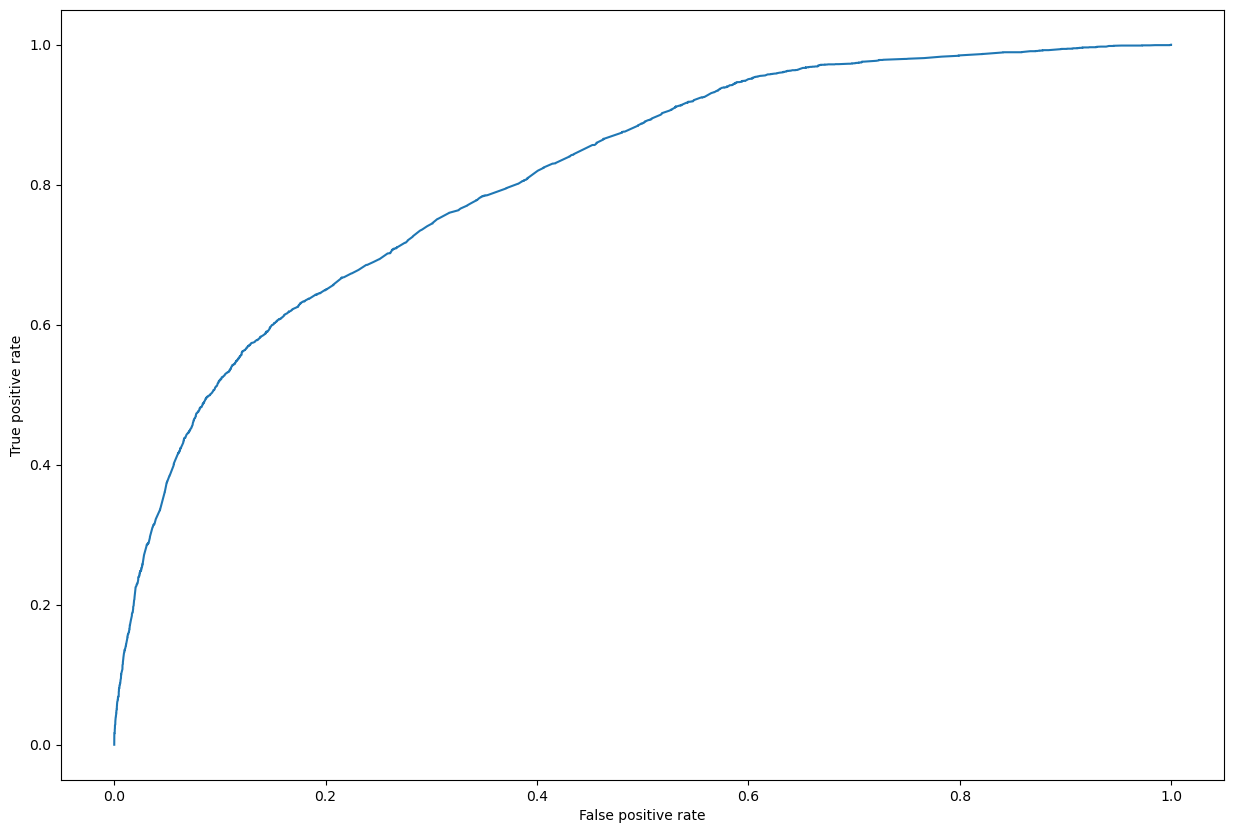

In [38]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, positive_proba)

plt.figure(figsize=(15, 10))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")